  # Test of MLP model
  
 
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter

from scipy.stats import randint as sp_randint
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import BalancedBatchGenerator
from imblearn.keras import balanced_batch_generator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Softmax
from tensorflow.keras.utils import plot_model

  ### Definition of names for plots and files

In [2]:

date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v5/dfcrossmatches_prioritized_v5.csv'

features_file = '../ZTF_data/features20191119_withWISE.csv'

class_output = '../ZTF_classifications/MLP_noe_hierarchical_classification_unlabelled_set_withWISE_20191119.csv'

#where the RF models are saved
model_name = 'stat_MLP/MLP_neo_hierarchical_'+date

#confusion matrixes
conf_matrix_name = 'stat_MLP/confusion_matrix_MLP_neo_hierarchical_'+date


In [3]:
mapper = {'SNIa':0, 
 'SNIbc':1, 
 'SNII':2,
 'SLSN':3,
 'QSO':4,
 'AGN':5, 
 'Blazar':6, 
 'CV/Nova':7,
 'LPV':8,
 'YSO':9,
 'EBSD/D':10, 
 'EBC': 11, 
 'DSCT': 12, 
 'RRL': 13, 
 'Ceph': 14, 
 'RSCVn': 15,
 'Periodic-Other':16
}
def encode(y):
    return y.apply(lambda x: mapper[x])

def encode_array(y):
    #return np.apply_along_axis(lambda x: mapper[x],y,0)
    return [mapper[x] for x in y ]


def decode(y):
    de_mapper = dict(zip(mapper.values(),mapper.keys()))
    return y.apply(lambda x: de_mapper[x])

def decode_array(y):
    de_mapper = dict(zip(mapper.values(),mapper.keys()))
    #return np.apply_along_axis(lambda x: de_mapper[x],y,0)
    return [de_mapper[x] for x in y ]



### reading the training set files 

In [4]:
#df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')


#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'W2-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'W2-W3']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 
#'''



#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


170976


In [5]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
#df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
#df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
#df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'



#defining the classes included in the RF model
label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'LPV','RSCVn','Periodic-Other']

#label_order = ['QSO-I','AGN-I', 'Blazar']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

labels.head()

,class_original
oid,
ZTF19aavdfaf,CV/Nova
ZTF19aaniokz,CV/Nova
ZTF18accatjz,CV/Nova
ZTF19aarfrrf,CV/Nova
ZTF19aarfrre,CV/Nova


In [6]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',#'W1-W2'    
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original']]
df.drop(['Mean_1','Mean_2','class_original'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

112045
112045
112045
112045


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abcoxgp,54.0,1.777661,1.0,6.0,0.611111,0.019231,0.469122,-2.518495,0.563044,0.054041,...,6.421510,6.025469,0.129630,0.187500,0.886667,0.983125,0.039,2.122,6.797622,4.675622
ZTF18aaavxnm,28.0,1.545494,1.0,1.0,0.107143,0.000000,1.098733,2.110676,0.569369,0.040964,...,9.510968,6.567360,0.678571,0.769231,0.810000,1.000000,0.439,1.925,4.709099,2.784099
ZTF18abmefme,50.0,1.741148,1.0,1.0,0.520000,0.000000,1.358764,-1.566153,0.813194,0.068374,...,3.444530,3.397257,0.440000,0.413043,0.918333,0.996042,0.168,2.829,4.799764,1.970764
ZTF17aabumpu,30.0,1.484850,1.0,1.0,0.166667,0.000000,0.000388,2.675668,2.922255,0.054713,...,4.392597,-0.795429,0.800000,0.666667,0.750000,0.790198,0.026,0.576,2.404230,1.828230
ZTF18aazmwvg,49.0,2.734478,1.0,2.0,0.428571,0.021277,0.001367,-3.255004,197.232789,0.101743,...,6.564860,6.794348,0.571429,0.655738,0.792857,0.980625,0.440,3.472,4.365933,0.893933


  ### Defining functions to plot the confusion matrix and the feature importance

In [7]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [8]:
Y_original = labels['class_original']

Y_original_encoded = encode(Y_original)
print(Y_original_encoded)
X_original = df.values


#splitting training set
X_train_original, X_test_original, y_train_original, y_test_original = model_selection.train_test_split(X_original,
                                                Y_original_encoded, test_size=0.2, stratify=Y_original_encoded)

'''scaler = MinMaxScaler()
scaler.fit(X_train_original)'''

scaler = QuantileTransformer(n_quantiles=1000, random_state=0)
scaler.fit(X_train_original)

X_train = scaler.transform(X_train_original)-0.5
X_test = scaler.transform(X_test_original)-0.5

X_train, X_valid, y_train_original, y_valid_original = model_selection.train_test_split(X_train,
                                                y_train_original, test_size=0.2, stratify= y_train_original)

y_train = keras.utils.to_categorical(y_train_original.values, len(label_order))
y_valid = keras.utils.to_categorical(y_valid_original.values, len(label_order))
y_test = keras.utils.to_categorical(y_test_original.values, len(label_order))

print(len(y_train_original))
print(X_train.shape[1])
print(y_train)

oid
ZTF18abcoxgp     7
ZTF18aaavxnm     7
ZTF18abmefme     7
ZTF17aabumpu     7
ZTF18aazmwvg     7
                ..
ZTF18aabkuwa    13
ZTF17aabwodu    13
ZTF18aaaqvuc    13
ZTF18acpdxhp    13
ZTF18acnokib    13
Name: class_original, Length: 112045, dtype: int64
71708
136
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  ## Balanced MLP
  

In [9]:
#defining the MLP:


features = Input(shape=(X_train_original.shape[1],))
root = Dense(256,activation='relu',name='DenseInput')(features)
root = Dropout(0.5,name='DenseDropout')(root)
root = Dense(128,activation='relu',name='Dense')(root)
root = Dropout(0.5,name='DenseDropout2')(root)
transient_in = Dense(128,activation='relu',name='TransientInput')(root)
transient_in = Dropout(0.5,name='TransientDropout')(transient_in)
transient_in = Dense(64,activation='relu',name='Transient')(transient_in)
transient_in = Dropout(0.5,name='TransientDropout2')(transient_in)
transient_out = Dense(4,activation='relu',name='TransientOutput')(transient_in)
stochastic_in = Dense(256,activation='relu',name='StochasticInput')(root)
stochastic_in = Dropout(0.5,name='StochasticDropout')(stochastic_in)
stochastic_in = Dense(128,activation='relu',name='Stochastic')(stochastic_in)
stochastic_in = Dropout(0.5,name='StochasticDropout2')(stochastic_in)
stochastic_out = Dense(6,activation='relu',name='StochasticOutput')(stochastic_in)
periodic_in = Dense(256,activation='relu',name='PeriodicInput')(root)
periodic_in = Dropout(0.5,name='PeriodicDropout')(periodic_in)
periodic_in = Dense(128,activation='relu',name='Periodic')(periodic_in)
periodic_in = Dropout(0.5,name='PeriodicDropout2')(periodic_in)
periodic_out = Dense(7,activation='relu',name='PeriodicOutput')(periodic_in)
outs = Concatenate(name='Concatenate')([transient_out, stochastic_out, periodic_out])
outs = Softmax(name='Softmax')(outs)
model = Model(inputs=features, outputs=outs)


#model.compile(loss=CategoricalCrossentropy(label_smoothing=0.2), optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) 
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) 




training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, 
                                      sampler=RandomOverSampler(), batch_size=len(label_order)*4)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model.fit_generator(generator=training_generator, steps_per_epoch=500,epochs=600, verbose=1,
                                       callbacks=[early_stop],validation_data=(X_valid, y_valid))

Epoch 1/600
500/500 [==============================] - 14s 28ms/step - loss: 2.2336 - accuracy: 0.2521 - val_loss: 1.0905 - val_accuracy: 0.6295
Epoch 2/600
500/500 [==============================] - 16s 32ms/step - loss: 1.4516 - accuracy: 0.4752 - val_loss: 1.0170 - val_accuracy: 0.6497
Epoch 3/600
500/500 [==============================] - 14s 29ms/step - loss: 1.2795 - accuracy: 0.5429 - val_loss: 0.9533 - val_accuracy: 0.6744
Epoch 4/600
500/500 [==============================] - 15s 29ms/step - loss: 1.1656 - accuracy: 0.5913 - val_loss: 0.9255 - val_accuracy: 0.6764
Epoch 5/600
500/500 [==============================] - 15s 29ms/step - loss: 1.0859 - accuracy: 0.6262 - val_loss: 0.8067 - val_accuracy: 0.7396
Epoch 6/600
500/500 [==============================] - 14s 28ms/step - loss: 1.0236 - accuracy: 0.6470 - val_loss: 0.8781 - val_accuracy: 0.7043
Epoch 7/600
500/500 [==============================] - 14s 28ms/step - loss: 0.9827 - accuracy: 0.6667 - val_loss: 0.8464 - val_ac

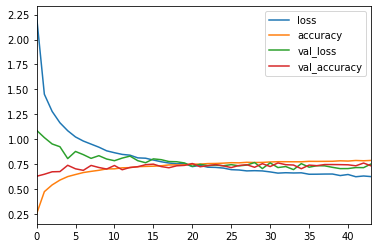

In [10]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

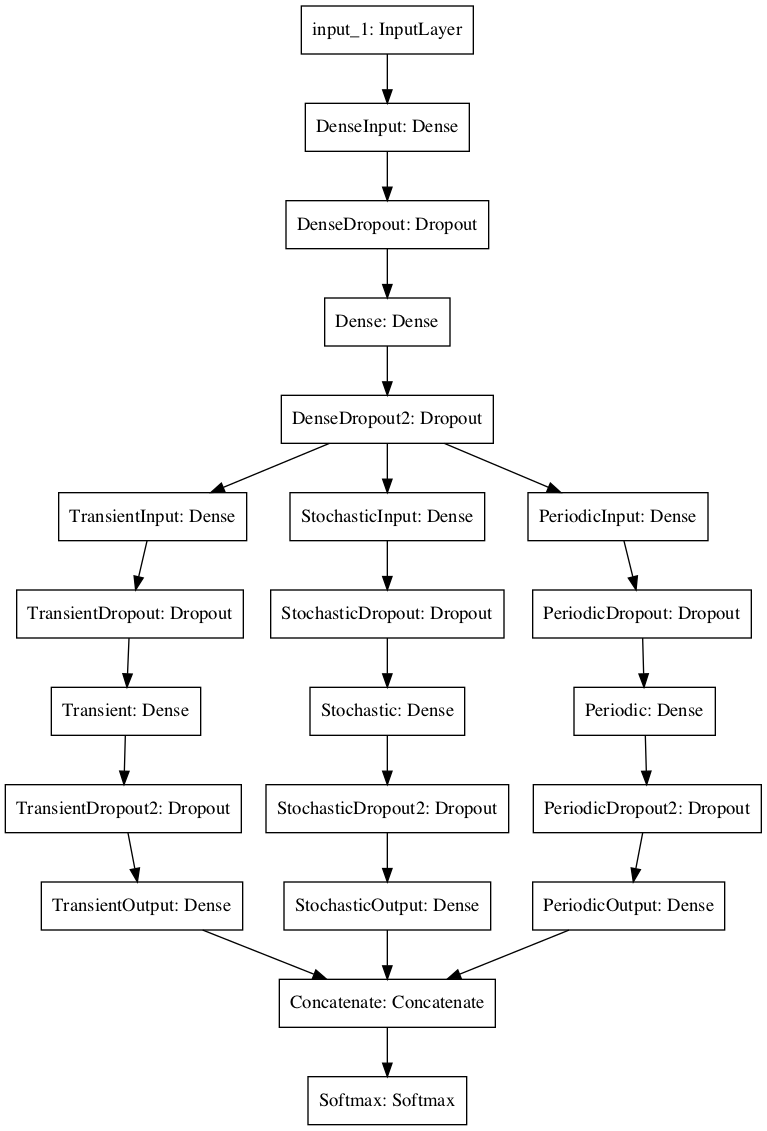

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [12]:
#predictions = model.predict_classes(X_test)
pred_proba = model.predict(X_test)
final_proba = np.amax(pred_proba,axis=1)
predictions = np.argmax(pred_proba,axis=1)
print(predictions)
predictions_names = decode_array(predictions)

print(predictions_names)

[15  4 10 ... 15 10 13]
['RSCVn', 'QSO', 'EBSD/D', 'EBC', 'RRL', 'DSCT', 'LPV', 'RRL', 'AGN', 'RRL', 'LPV', 'RSCVn', 'EBC', 'EBC', 'LPV', 'QSO', 'RRL', 'EBC', 'QSO', 'LPV', 'QSO', 'EBC', 'EBSD/D', 'EBSD/D', 'LPV', 'RRL', 'YSO', 'LPV', 'RRL', 'EBSD/D', 'QSO', 'RRL', 'AGN', 'LPV', 'EBSD/D', 'YSO', 'LPV', 'EBSD/D', 'RSCVn', 'LPV', 'LPV', 'Ceph', 'RRL', 'EBSD/D', 'LPV', 'LPV', 'RRL', 'LPV', 'RRL', 'EBSD/D', 'EBC', 'AGN', 'RRL', 'LPV', 'EBC', 'AGN', 'QSO', 'RRL', 'LPV', 'RRL', 'EBSD/D', 'LPV', 'LPV', 'RRL', 'EBC', 'LPV', 'RRL', 'EBC', 'EBSD/D', 'RRL', 'LPV', 'EBSD/D', 'RRL', 'LPV', 'RRL', 'EBSD/D', 'Ceph', 'EBSD/D', 'RRL', 'LPV', 'RRL', 'EBSD/D', 'RRL', 'RRL', 'EBSD/D', 'LPV', 'LPV', 'RRL', 'Periodic-Other', 'LPV', 'RRL', 'EBC', 'RRL', 'EBSD/D', 'RRL', 'LPV', 'EBC', 'RRL', 'RRL', 'RRL', 'Periodic-Other', 'RRL', 'LPV', 'RRL', 'EBC', 'RRL', 'QSO', 'QSO', 'LPV', 'Periodic-Other', 'EBC', 'LPV', 'DSCT', 'EBSD/D', 'EBSD/D', 'EBSD/D', 'CV/Nova', 'QSO', 'Periodic-Other', 'EBSD/D', 'RRL', 'Ceph', 'R

In [28]:


print("Accuracy:", metrics.accuracy_score(y_test_original, predictions))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, predictions))
print("weighted precision: ", metrics.precision_score(y_test_original, predictions, average='weighted'))
print("weighted F1: ", metrics.f1_score(y_test_original, predictions, average='weighted'))



#Dumping trained model

features_list = list(X_train_original)


Accuracy: 0.7365790530590388
Balanced accuracy: 0.6150813642607715
weighted precision:  0.8512406832971104
weighted F1:  0.7697734406283016


In [14]:
print(y_test)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[1438  282   49    2   17    0    0    4    0    2    1    4    2    0
     1    3    2]
 [  39  354   18    4    6    3    1    4    0    0    0    0    0    0
     1    0    0]
 [  26   25  118    1   10    0    0    2    0    0    0    0    0    0
     0    0    0]
 [   0    1    7  114    6    5    2    1    0    2    2    5    1    0
     1    2    7]
 [   0    6    5    3  237    0    0    2    0    0    3    1    0    3
    16   11    0]
 [   0    1    0    2    0  134    3   13    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    4    1    5    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0   11    0   28    3    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    2    0    2    0    0    0    0    0    0
     0    0    0]
 [   4    2    1   40   42    0    0    1    0 2085 1611  301  106   54
    14  508  271]
 [   0    0    1   11   12    0    0    0    0  301  720   98   28   25
     1  116   43]
 [   0    

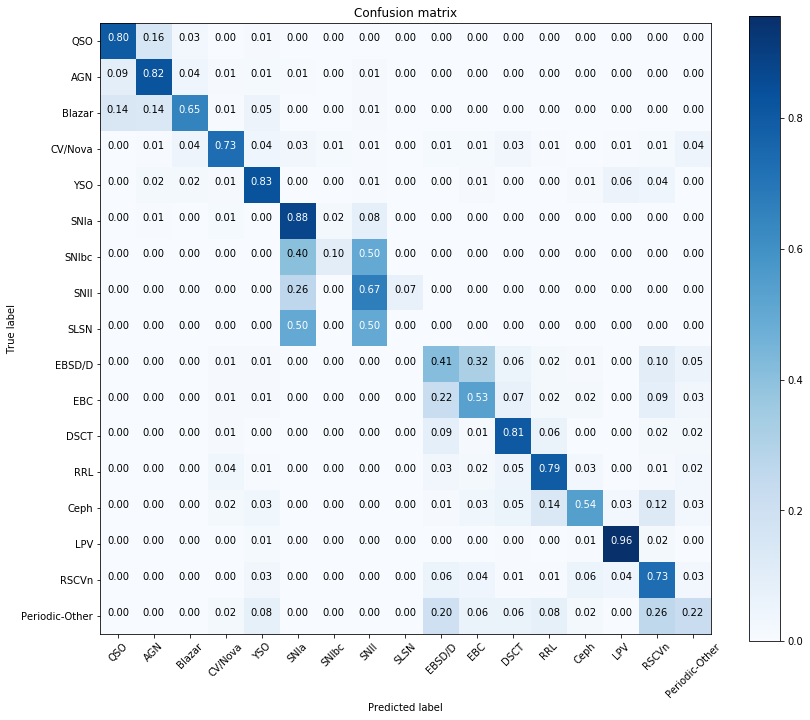

In [15]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(decode_array(y_test_original), decode_array(predictions), labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,conf_matrix_name)

In [16]:
# Kaggle score

CLASSES_REDUCED_V2 = label_order


class_weights = list(class_weight.compute_class_weight('balanced', encode_array(label_order), y_test_original))


def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = encode_array(CLASSES_REDUCED_V2)#np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(y_test_original,pred_proba,class_weights))

YSO -3.9479731133688323
SNIa -4.847373970239633
SNIbc -104.31537303573944
SNII -38.96615099122211
EBSD/D -0.16805954949598131
QSO -0.34993735163983836
AGN -21.841803015371028
Blazar -17.82580352846699
CV/Nova -69.21496272087097
EBC -1.1711619869146044
DSCT -11.702812152424197
RRL -0.17875287250684563
Ceph -8.447422749916916
LPV -0.28123426399341456
SLSN -73.05315353743293
RSCVn -8.086820118682857
Periodic-Other -90.35935678033267
0.7789402157758524


  ## Classifying unlabeled data

In [17]:
#loading the data

print(df_feat.n_samples_1.size)
print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_samples_1.size)

    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()



653905
['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'paps_non_zero_1', 'paps_non_zero_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z']
653905


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-1.493229,1.000000,0.500000,0.626905,1.000000,-0.089,0.912,2.997933,2.085933
ZTF17aaaaaam,0.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,0.083333,0.635476,0.987167,0.038,0.565,5.909550,5.344550
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,0.011620,...,7.003891,-2.943499,0.459016,0.172414,0.730000,1.000000,-0.160,0.893,3.745013,2.852013
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,0.007609,...,33.561080,-0.202701,0.156250,0.325581,0.776667,0.999167,0.014,1.623,4.135574,2.512574
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,0.012610,...,1.285452,15.110684,0.844156,0.000000,0.838333,0.996667,0.006,1.001,4.327510,3.326510


In [18]:
#predicting classes of unlabeled data

x_test_scaled = scaler.transform(df_feat_ul)-0.5
print(x_test_scaled.shape)
test_Y_proba = model.predict(x_test_scaled)
test_Y_final_proba = np.amax(test_Y_proba,axis=1)
test_Y_predictions = np.argmax(test_Y_proba,axis=1)
test_Y_predictions_names = decode_array(test_Y_predictions)

print(len(test_Y_predictions_names))

(653905, 136)
653905


In [19]:
print(np.amax(test_Y_proba,axis=1))

[0.7764009  0.6291078  0.486897   ... 0.66351473 0.8429474  0.7753756 ]


In [20]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)

df_out['predicted_class'] = test_Y_predictions_names
df_out['predicted_class_proba'] = test_Y_final_proba
test_data_withclass = df_out

'''

probs_header = decode_array(np.arange(0,17))#prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(test_Y_proba,columns=probs_header,index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''

(653905, 136)


"\n\nprobs_header = decode_array(np.arange(0,17))#prob_final_class_names_ul + '_prob'\n\nprob_pd_ul = pd.DataFrame(test_Y_proba,columns=probs_header,index=df_out.index)\n\ntest_data_withclass = df_out.join(prob_pd_ul)\n\ntest_data_withclass.to_csv(class_output)\n\ntest_data_withclass.head()\n"

In [21]:
test_data_withclass.shape
#class_final_name_ul = le_original.inverse_transform(class_final_name_ul)

(653905, 138)

Text(0.5, 1.0, 'sources classified')

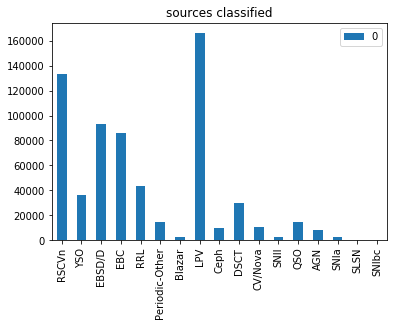

In [22]:
letter_counts = Counter(test_Y_predictions_names)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')


0 QSO 0.6114498972892761
1 AGN 0.775038480758667
2 Blazar 0.6764417886734009
3 CV/Nova 0.7106903195381165
4 YSO 0.6144530177116394
5 SNIa 0.9845640361309052
6 SNIbc 0.8286275863647461
7 SNII 0.7120777666568756
8 SLSN 0.97679203748703
9 EBSD/D 0.472407802939415
10 EBC 0.502729594707489
11 DSCT 0.4459306299686432
12 RRL 0.7475005984306335
13 Ceph 0.5506142973899841
14 LPV 0.8905766606330872
15 RSCVn 0.6945980191230774
16 Periodic-Other 0.5139292180538177


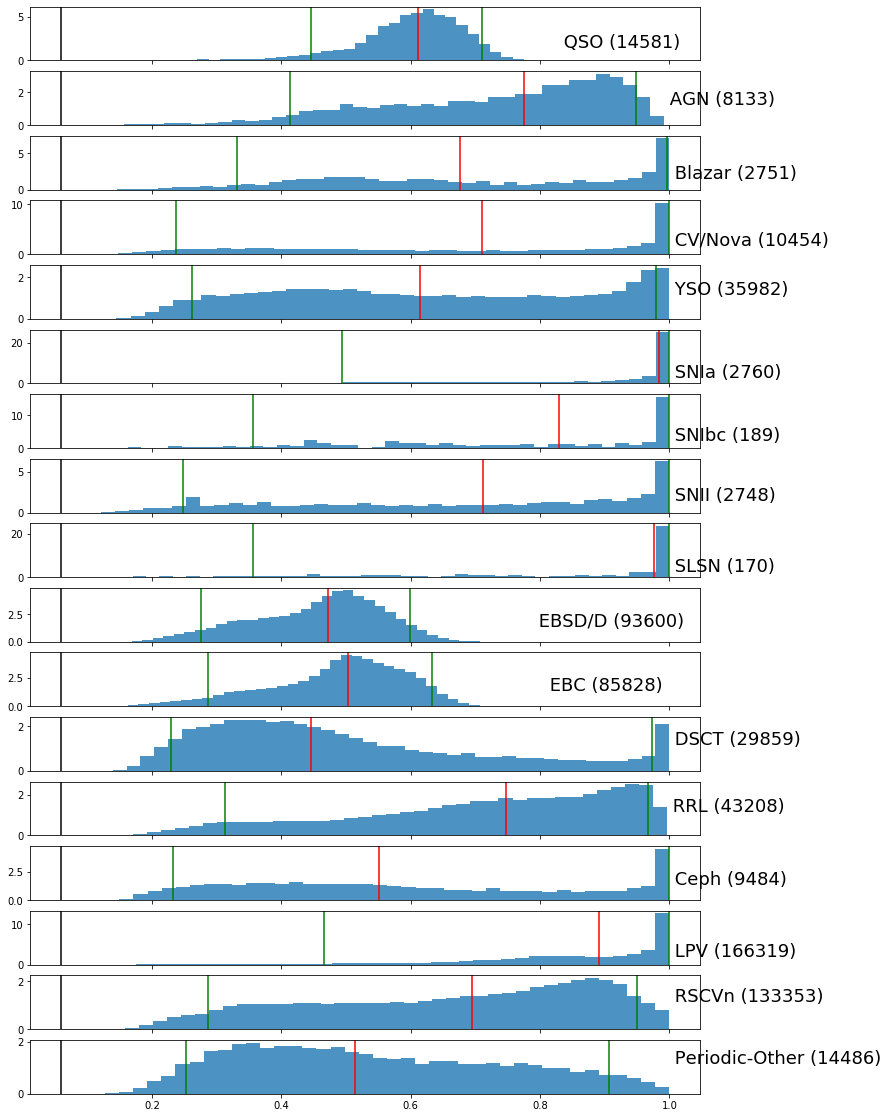

In [23]:

fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

0 QSO 0.1147390363563936
1 AGN 0.15682017322190234
2 Blazar 0.3936305181058977
3 CV/Nova -0.026105408408150232
4 YSO 1.495713483800902
5 SNIa 0.012903213500999655
6 SNIbc 0.4346666336059499
7 SNII 0.18158149719244854
8 SLSN 0.1410846710205007
9 EBSD/D 0.5472286327336491
10 EBC 0.568156998689302
11 DSCT 0.03726910503009862
12 RRL 0.059677279655499404
13 Ceph 0.7970160313865993
14 LPV 2.2658787508913
15 RSCVn 0.8990823419966016
16 Periodic-Other 0.4875497713696007


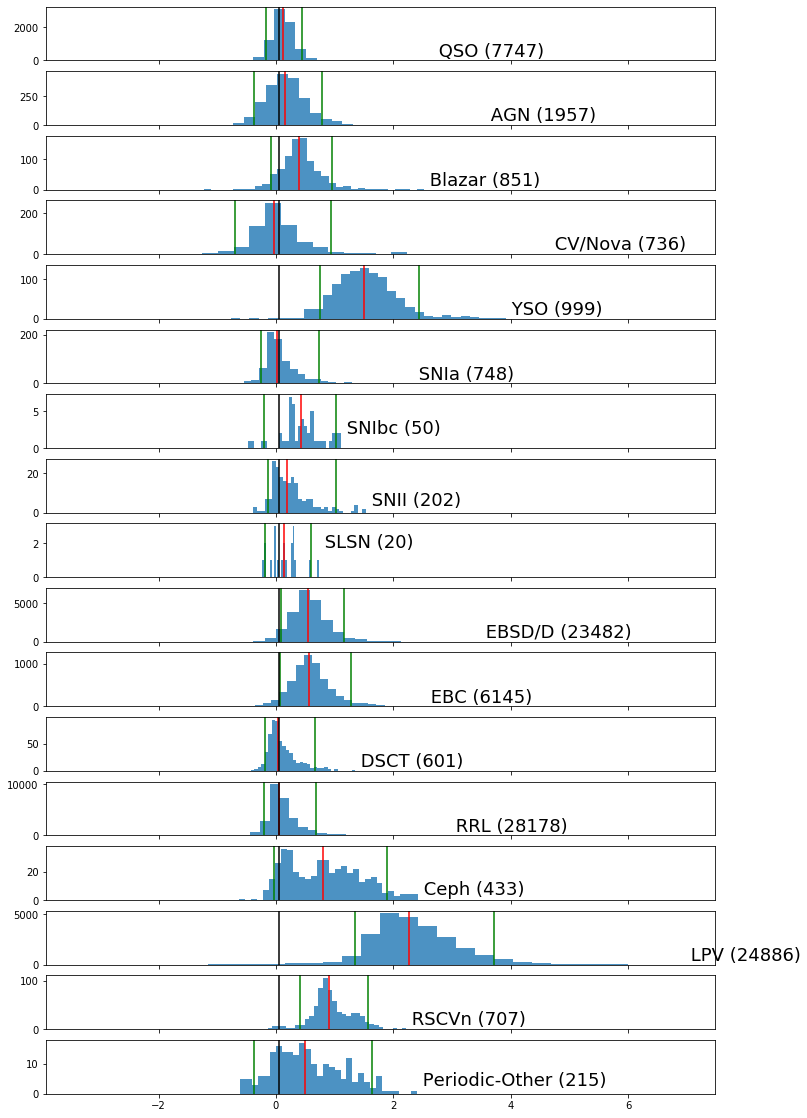

In [24]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

QSO 12202
AGN 7064
SNIa 2597
SNIbc 186
SNII 2169
SLSN 165


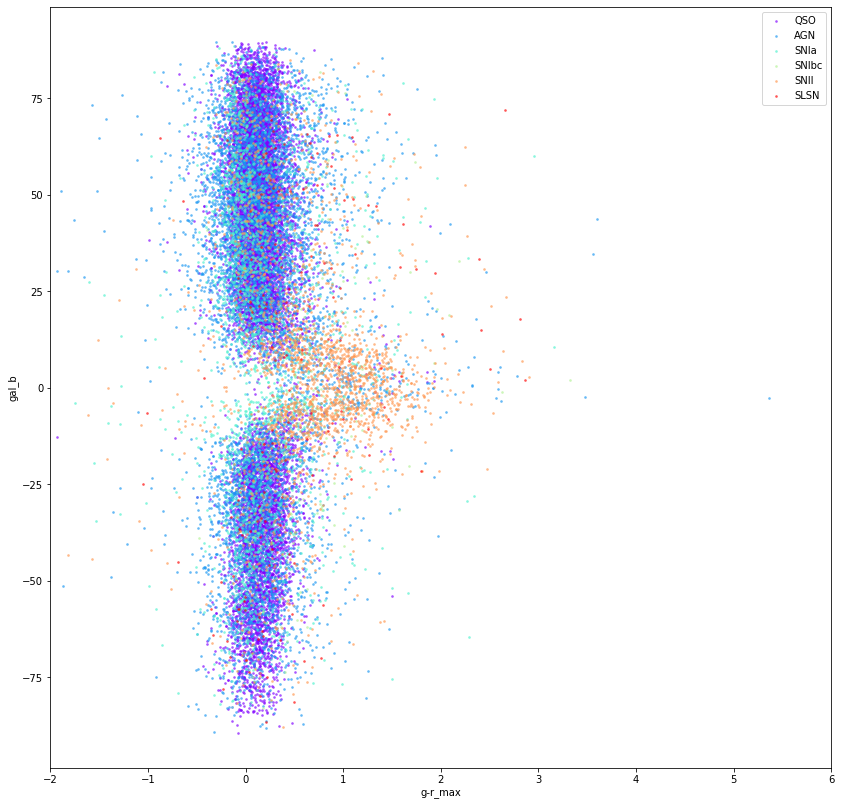

In [27]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['QSO','AGN','SNIa','SNIbc','SNII','SLSN']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   print(cl,len(df_test[feature_x][df_test['predicted_class']==cl].values))
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

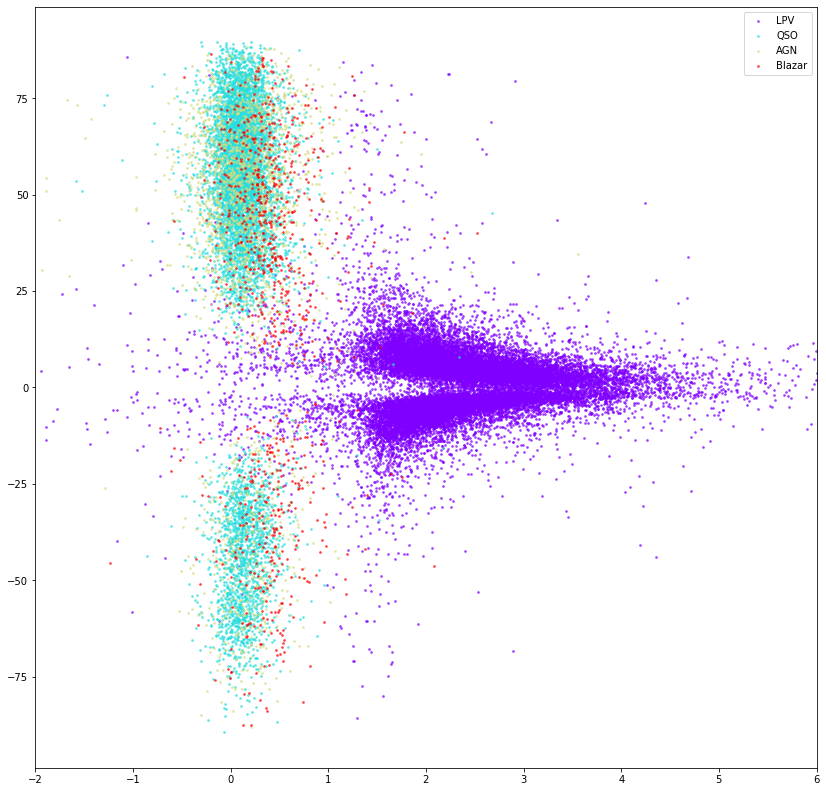

In [26]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO','AGN','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')